# Audio Transforms Manager

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#Export

#Internal dependencies
from exp.nb_AudioCommon import * 
from exp.nb_DataAugmentation import * 
from exp.nb_FastWidgets import * 
from exp.nb_TransformsManager import * 

## Idea
The following picture is the initial idea of **AudioTfmsManager**: a simple tool that let's you visually explore the contribution of the different transformations.

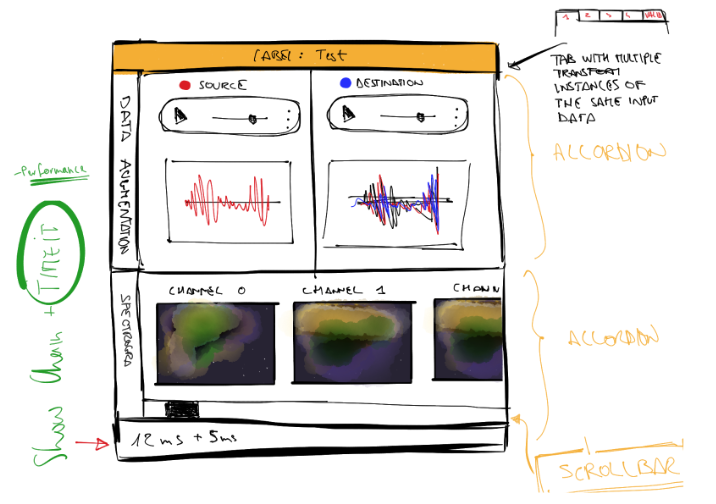

### Audio sample data

In [3]:
# Download data in fast.ai format (thnx @Thom)
data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
path = datapath4file('ST-AEDS-20180100_1-OS')
untar_data(data_url, dest = path)

PosixPath('/home/ste/.fastai/data/ST-AEDS-20180100_1-OS/ST-AEDS-20180100_1-OS')

In [4]:
sampleFile = path.ls()[4]
sampleFile

PosixPath('/home/ste/.fastai/data/ST-AEDS-20180100_1-OS/f0002_us_f0002_00263.wav')

In [5]:
sampleSound = AudioData.load(sampleFile)
display(Audio(sampleSound.sig,rate=sampleSound.sr))

### AudioTfmsManager

In [6]:
#Export
class AudioTfmsManager(TfmsManager):
    
    def try_data_augmentation(self,ad:AudioData, lbl:str=None, showResults=True, **kwargs)->AudioData:
        '''Try to apply data augmentation only and show labels'''
        tfms = self.get_train_tfms(2)
        y=applyTfms(tfms,ad) # All tfms
        if showResults: 
            out=widgets.Output()
            with out:
                self.showAudio(y,lbl,ad,**kwargs)
            display(getResultAndTfmsWidget(out,tfms))
        return y
    
    def try_spectrogram(self,ad:AudioData, lbl:str=None, showResults=True, **kwargs):
        '''Apply all other tfms after data augmentation'''
        tfms = getTfmList(self.train_tfmsg[(2+1):])
        y=applyTfms(tfms,ad) # All valid tfms - no data augmentation
        if showResults: 
            out=widgets.Output()
            with out:
                self.showSpec(y,lbl,**kwargs)
            display(getResultAndTfmsWidget(out,tfms))
        return y
    
    def try_train_tfms(self,ad:AudioData, lbl:str=None, showResults=True, **kwargs):
        '''Try to apply all train transforms to an audio signal'''
        y, yaug=None, None
        #Aug
        aug = widgets.Output()
        with aug:
            yaug=self.try_data_augmentation(ad,lbl=None,showResults=True,**kwargs)

        spec = widgets.Output()
        with spec:
            y = self.try_spectrogram(yaug, lbl=None, **kwargs)
        
        wAug = fastCard('DATA AUGMENTATION AND SIZE (AudioData):', aug, text_align='left', title_background_color='lavender')
        wSpec = fastCard('SPECTROGRAM:  (Image)', spec, text_align='left', title_background_color='lavender')

        wFooter = fastCard(f'RESULT: type={type(y)} shape={y.shape}', text_align='left', title_background_color=None)
        
        out = display(fastCard(lbl,widgets.VBox(children=[wAug,wSpec,wFooter]),
                               color='white',title_background_color='black'))
        display(out)
        return y        
    
    def showAudio(self, dst:AudioData, lbl, src:AudioData=None, showSound=True, showPlot=True, showSource=True, **kwargs):
        if showSound: 
            if(lbl): display(f'Label: {lbl}')
            wSrc = getAudioWidget(src,'ORIGINAL', text_align='center') # empty widget if none...
            wDst = getAudioWidget(dst,'AUGMENTED', text_align='center')
            wrow = widgets.HBox(children = [wSrc, wDst])
            display(wrow)
        if showPlot:
            if (src is not None) and showSource: plt.plot(src.sig, 'r')
            if dst is not None: plt.plot(dst.sig, 'b')
            plt.show() # Force chart to display

    def showSpec(self, spec:torch.Tensor, lbl:str=None, **kwargs):
        '''Shape Should be (n_channels,hh,ww)'''
        if lbl: display(f'Label: {lbl}')
        toShow = []
        for i in range(spec.shape[0]):
            img = spec[i,:,:].unsqueeze(0) # need to unsqueeze because Image whats 1xHxW
            toShow.append(fastCard(f'C:{i}', getImageWidget(img)))
        if toShow: display(widgets.HBox(children=toShow))
            
    @classmethod
    def get_audio_tfms_manager(cls,
                             spectro:bool=False,
                             white_noise:bool=True,
                             modulate_volume:bool=True,
                             random_cutout:bool=True,
                             pad_with_silence:bool=True,
                             pitch_warp:bool=True,
                             down_and_up:bool=True,
                             mx_to_pad:int=1000,
                             xtra_pre_tfms:TfmList=None,
                             xtra_aug_tfms:TfmList=None,
                             xtra_post_tfms:TfmList=None,
                             **kwargs)->TfmsManager:
        '''factory to create audio transforms manager.'''
        pre = [] + listify(xtra_pre_tfms)
        
        aug = []
        if white_noise: aug.append(partial(tfm_add_white_noise, **kwargs))
        if modulate_volume: aug.append(partial(tfm_modulate_volume, **kwargs))
        if random_cutout: aug.append(partial(tfm_random_cutout, **kwargs))
        if pad_with_silence: aug.append(partial(tfm_pad_with_silence, **kwargs))
        if pitch_warp: aug.append(partial(tfm_pitch_warp, **kwargs))
        if down_and_up: aug.append(partial(tfm_down_and_up, **kwargs))
        aug += listify(xtra_aug_tfms)

        size = []
        if mx_to_pad: size.append(partial(tfm_pad_to_max, mx=mx_to_pad))
        
        post = []
        post += [partial(tfm_spectro, **kwargs) if spectro else partial(tfm_extract_signal, **kwargs)]
        post += listify(xtra_post_tfms)
        
        return cls([pre,aug,size,post],[pre,size,post])

In [7]:
#Show all results
tm=AudioTfmsManager.get_audio_tfms_manager(
                         spectro=True, n_mels=256, ws=300, n_fft=3200, to_db_scale=True,
                         white_noise=True, noise_scl=.00052,
                         modulate_volume=False,
                         random_cutout=False,
                         pad_with_silence=False,
                         pitch_warp=False,
                         down_and_up=False,
                         mx_to_pad=32000)
tm.try_train_tfms(sampleSound,'Show all');

None

In [8]:
def test_get_audio_tfms_manager():
    tm=AudioTfmsManager.get_audio_tfms_manager()

    # fast.ai integration
    tfms = tm.get_tfms()
    print('fast.ai tfms = ',tfms)
    assert 2==len(tfms), 'tfms tuple for fast.ai'
    assert 8==len(tfms[0]), 'train transformations'
    assert 2==len(tfms[1]), 'valid transformations'
    
    assert 8==len(tm.get_train_tfms())
    assert 2==len(tm.get_valid_tfms())
    assert 7==len(tm.get_train_tfms(2)) # data augmentation -> pre+aug
    
    tm=AudioTfmsManager.get_audio_tfms_manager(
                         spectro=True,
                         white_noise=False,
                         modulate_volume=False,
                         random_cutout=False,
                         pad_with_silence=False,
                         pitch_warp=False,
                         down_and_up=False,
                         mx_to_pad=1000)
    assert 2==len(tm.get_train_tfms())
    assert 2==len(tm.get_valid_tfms())

    print('DONE')
    
test_get_audio_tfms_manager()

fast.ai tfms =  [[functools.partial(<function tfm_add_white_noise at 0x7fb5002e6378>), functools.partial(<function tfm_modulate_volume at 0x7fb5002e6400>), functools.partial(<function tfm_random_cutout at 0x7fb5002e6488>), functools.partial(<function tfm_pad_with_silence at 0x7fb5002e6510>), functools.partial(<function tfm_pitch_warp at 0x7fb5002e6598>), functools.partial(<function tfm_down_and_up at 0x7fb5002e6620>), functools.partial(<function tfm_pad_to_max at 0x7fb5002e6730>, mx=1000), functools.partial(<function tfm_extract_signal at 0x7fb5002e68c8>)], [functools.partial(<function tfm_pad_to_max at 0x7fb5002e6730>, mx=1000), functools.partial(<function tfm_extract_signal at 0x7fb5002e68c8>)]]
DONE


### SAMPLE USAGE FOR AUDIO
Pretend that you want identify who is talking in a registratio. This is a tipical classificaiton problem. A way to address this problem is taking the first 2 seconds of the original sound, converting it into a MEL spectrogram and feed a CNN to classify it as it was an image.

If you want to improve the performance and the generalization of your model, one simple way is to use data augmentation, like on images.
The problem with sound is that you need to make the data augmentation (**AUG**) on the original sound, and to understand if you're doing this correctly you need to "HEAR" (listen) and "VIEW" (plot soundwave) your augmented sound.
Moreover, once you're sure about your data augmentation, you need to tune your spectrogram (**POST**) in such way that you're preserve as much information as possible for the next steps.

TfmsManager can help you in all this steps, so you can create and test independently all the transformation groups that you need. 

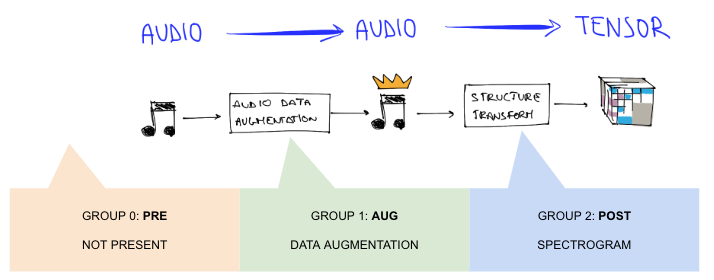

Download some test data...

### TfmsManager sample usage:
With AudioTfmsManager you can easily test separately all your transformation groups:
* DATA AUGMENTATION (AUG)
* SPECTROGRAM (POST)
<br>
<br>
Having a quick audio/visual feedback on them.

In [9]:
#Show all results
tm=AudioTfmsManager.get_audio_tfms_manager(
                         spectro=True, n_mels=256, ws=300, n_fft=3200, to_db_scale=True,
                         white_noise=True, noise_scl=.00052,
                         modulate_volume=False,
                         random_cutout=False,
                         pad_with_silence=False,
                         pitch_warp=False,
                         down_and_up=False,
                         mx_to_pad=32000)
tm.try_train_tfms(sampleSound,'Show all');

None

In [10]:
#Show efect of data augmentation only
tm.try_data_augmentation(sampleSound,'Show data augmentatio on signal only');

In [11]:
#Show effects of spectrogram only
tm.try_spectrogram(sampleSound,'Spectrogram without data augmentation');

### Use case: find correct parameters for data augmentation  

In [12]:
tm=AudioTfmsManager.get_audio_tfms_manager(spectro=True)
tm.try_data_augmentation(sampleSound,'test')

**WARNING**: these transformations completely destroy the original information...

In [13]:
tm=AudioTfmsManager.get_audio_tfms_manager(
                         spectro=True,
                         white_noise=True, noise_scl=.00052,
                         modulate_volume=False,
                         random_cutout=False,
                         pad_with_silence=False,
                         pitch_warp=False,
                         down_and_up=False,
                         mx_to_pad=32000)    
tm.try_data_augmentation(sampleSound,'test')

### Use case: find correct parameters for spectrogram generation and multi spectrogram

In [14]:
def tfm_cropSpec(spec:torch.Tensor, yStart, yEnd)->torch.Tensor:
    #yStart = int(math.floor(yStart))
    #yEnd = int(math.floor(yEnd))
    #print(spec.shape, yStart, yEnd, yEnd-yStart)
    ret = spec[:,:,yStart:yEnd]
    #print(ret.shape)
    return ret

def tfm_multiSpectrumSlide(ad:AudioData, max_duration=1600, n_windows = 3)->torch.Tensor:
    '''This transformation is going to produce a 3-channels spectrum image from sliding windows'''
    minLenForSpec = 6401
    maxWW = max(minLenForSpec,max_duration) # max width
    
    padded = tfm_pad_to_max(ad, maxWW) # Ensure constant lenght
    spec = tfm_spectro(padded, n_mels=224, ws=50, n_fft=3200*2, to_db_scale=True) # Spectrogram of all

    wndWidth = 140 # in spec cols
    maxSpecCols = spec.shape[2]
    
    wndStep = (maxSpecCols - wndWidth)/(n_windows-1)
    wndStep = int(math.floor(wndStep)) # make it integer
    
    #print(wndWidth, wndStep)
    
    n=0
    ret = None
    ret = tfm_cropSpec(spec,(n*wndStep),((n)*wndStep)+wndWidth) # Sliding window
    wMax = ret.shape[2]
    
    for n in range(1,n_windows):
        img = tfm_cropSpec(spec,(n*wndStep),((n)*wndStep)+wndWidth)
        ret = torch.cat([ret,img],dim=0) # Stack...
    
    return ret

In [15]:
tm=AudioTfmsManager.get_audio_tfms_manager(
                         spectro=True, n_mels=256, ws=300, n_fft=3200, to_db_scale=True,
                         white_noise=True, noise_scl=.0052,
                         modulate_volume=True,
                         random_cutout=True,
                         pad_with_silence=False,
                         pitch_warp=True,
                         down_and_up=False,
                         mx_to_pad=32000)

#Replace the spectrogram transform with tfm_spectro_stft
filan_spec_tfm = partial(tfm_multiSpectrumSlide, max_duration=1000)
tm.train_tfmsg[-1]=[filan_spec_tfm]
tm.valid_tfmsg[-1]=[filan_spec_tfm]

#Try!
yOut = tm.try_train_tfms(sampleSound,'test')
yOut.shape

None

torch.Size([3, 224, 140])

In [16]:
tm=AudioTfmsManager.get_audio_tfms_manager(
                         spectro=True, n_mels=256, ws=300, n_fft=3200, to_db_scale=True,
                         white_noise=True, noise_scl=.0052,
                         modulate_volume=True,
                         random_cutout=True,
                         pad_with_silence=False,
                         pitch_warp=False,
                         down_and_up=False,
                         mx_to_pad=32000)

#Replace the spectrogram transform with tfm_spectro_stft
filan_spec_tfm = partial(tfm_multiSpectrumSlide, max_duration=1000, n_windows=8)
tm.train_tfmsg[-1]=[filan_spec_tfm]
tm.valid_tfmsg[-1]=[filan_spec_tfm]

#Try!
yOut = tm.try_train_tfms(sampleSound,'test')
yOut.shape

None

torch.Size([8, 224, 140])

In [17]:
#These are actually the transforms applied to the train set
for i,g in enumerate(tm.train_tfmsg):
    print(f'[{i}]: ' + str(g))

[0]: []
[1]: [functools.partial(<function tfm_add_white_noise at 0x7fb5002e6378>, n_mels=256, ws=300, n_fft=3200, to_db_scale=True, noise_scl=0.0052), functools.partial(<function tfm_modulate_volume at 0x7fb5002e6400>, n_mels=256, ws=300, n_fft=3200, to_db_scale=True, noise_scl=0.0052), functools.partial(<function tfm_random_cutout at 0x7fb5002e6488>, n_mels=256, ws=300, n_fft=3200, to_db_scale=True, noise_scl=0.0052)]
[2]: [functools.partial(<function tfm_pad_to_max at 0x7fb5002e6730>, mx=32000)]
[3]: [functools.partial(<function tfm_multiSpectrumSlide at 0x7fb4d3da3d90>, max_duration=1000, n_windows=8)]


# Export

In [18]:
!python notebook2script.py AudioTransformsManager.ipynb

Converted AudioTransformsManager.ipynb to nb_AudioTransformsManager.py
